In [ ]:
import numpy as np  # linear algebra

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import tensorflow.keras.metrics
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import datetime

# Importing image data from Google Drive

In [ ]:
#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/landscape_Images.zip" -d "landscape_Images"

In [ ]:
ROOT_DIR = 'landscape_Images/landscape Images/'
GRAY_DIR = ROOT_DIR + 'gray/'
COLOR_DIR = ROOT_DIR + 'color/'
TEST_DIR = ROOT_DIR + 'test/'
RESULTS_DIR = ROOT_DIR + 'results/'
LIMIT = 7128
NORMALIZATION_FACTOR = 255.0
STEP_EPOCHS = 10
EPOCHS = 100
LESS_EPOCHS = 10

# The range of files in the Colored images directory

In [ ]:
file_names = os.listdir(COLOR_DIR)
file_names.sort(key=lambda x: int(x.split('.')[0]))
file_names = file_names[:LIMIT]
print('Range: ', file_names[0], file_names[-1], len(file_names))

Range:  0.jpg 7127.jpg 7128


# Sample images:

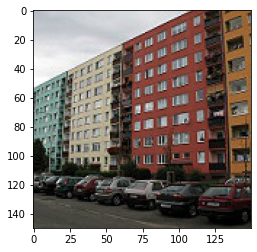

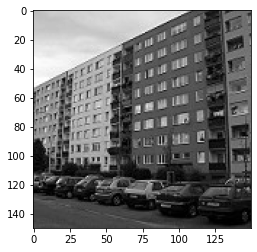

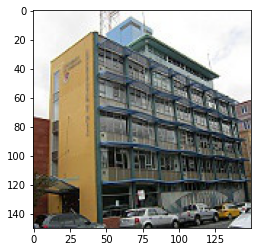

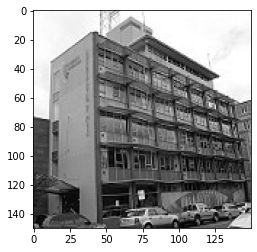

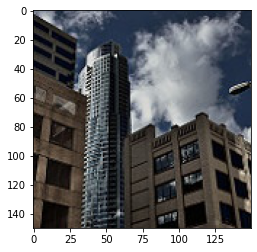

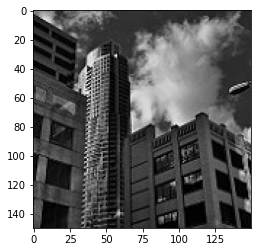

In [ ]:
for fileName in file_names[-3:]:
    color_img = mpimg.imread(COLOR_DIR + fileName)
    gray_img = mpimg.imread(GRAY_DIR + fileName)
    color_imgplot = plt.imshow(color_img)
    plt.show()
    gray_imgplot = plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Total number of colored images

In [ ]:
tot_color_images = len(os.listdir(COLOR_DIR)[:LIMIT])
tot_color_images

7128

# Total number of gray scaled images

In [ ]:
tot_gray_images = len(os.listdir(GRAY_DIR)[:LIMIT])
tot_gray_images

7128

# We will now need to resize and normalize all the input images to a preferable normal

In [ ]:
height, width, channel = 256, 256, 3
input_shape = (height, width, 1)
images_name = next(os.walk(COLOR_DIR))[2]
images_name = images_name[:LIMIT]

In [ ]:
# Resizing...
all_colored_images_normalized = np.zeros((len(images_name), height, width, channel), dtype=np.uint8)
all_gray_images_normalized = np.zeros((len(images_name), height, width), dtype=np.uint8)
for image_index, image_name in tqdm(enumerate(images_name)):
    # Adding image names with base directory to get full path for every images
    colored_image_path = COLOR_DIR + image_name + ''
    colored_image_info = imread(colored_image_path)

    gray_image_path = GRAY_DIR + image_name + ''
    gray_image_info = imread(gray_image_path)

    # Resizing every image to 256*256 as declared previously
    colored_image_info = resize(colored_image_info, (height, width), mode='constant', preserve_range=True)
    all_colored_images_normalized[image_index] = colored_image_info

    gray_image_info = resize(gray_image_info, (height, width), mode='constant', preserve_range=True)
    all_gray_images_normalized[image_index] = gray_image_info

# Normalizing values between 0 to 1 by diving
all_colored_images_normalized = all_colored_images_normalized.astype('float32') / NORMALIZATION_FACTOR
all_gray_images_normalized = all_gray_images_normalized.astype('float32') / NORMALIZATION_FACTOR

7128it [01:45, 67.82it/s]


In [ ]:
train_output, test_output = train_test_split(all_colored_images_normalized, test_size=0.2, random_state=25)
train_input, test_input = train_test_split(all_gray_images_normalized, test_size=0.2, random_state=25)

In [ ]:
len(train_output)

5702

In [ ]:
len(train_input)

5702

In [ ]:
len(test_output)

1426

In [ ]:
len(test_input)

1426

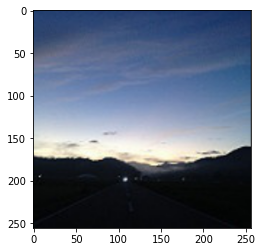

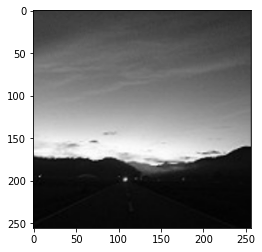

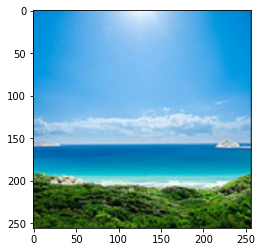

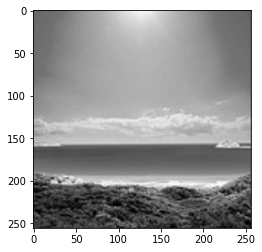

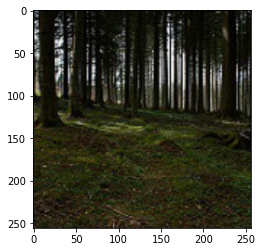

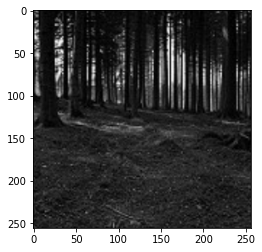

In [ ]:
for index in range(3):
    color_img_plt = plt.imshow(train_output[index])
    plt.show()
    gray_img_plt = plt.imshow(train_input[index], cmap='gray', vmin=0, vmax=1)
    plt.show()

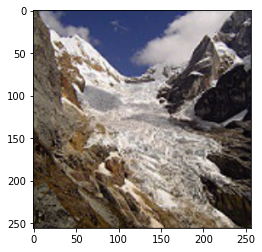

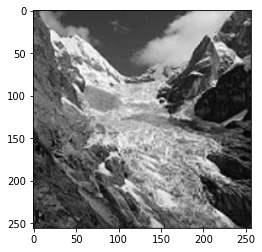

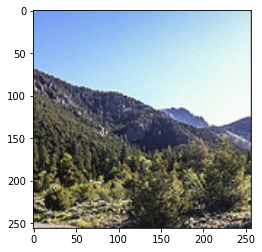

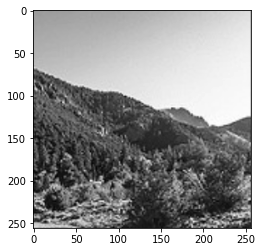

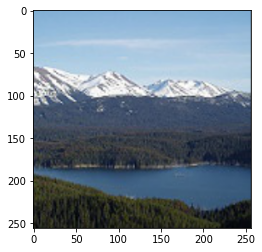

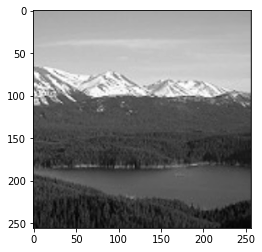

In [ ]:
for index in range(3):
    color_img_plt = plt.imshow(test_output[index])
    plt.show()
    gray_img_plt = plt.imshow(test_input[index], cmap='gray', vmin=0, vmax=1)
    plt.show()

In [ ]:
#Design the neural network
model = Sequential()

# Input Layer
model.add(InputLayer(input_shape=(256, 256, 1)))

# Encoding the input
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# Decode
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

In [ ]:
# Finish model
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

In [ ]:
# Image Augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True)

In [ ]:
# Generate training data in LAB color space
batch_size = 50

def image_a_b_gen(batch_size):
  for batch in datagen.flow(train_output, batch_size=batch_size):
      lab_batch = rgb2lab(batch)
      train_input_batch = lab_batch[:, :, :, 0]
      train_input_batch = train_input_batch.reshape(train_input_batch.shape + (1,))
      train_output_batch = lab_batch[:, :, :, 1:] / 128
      yield train_input_batch, train_output_batch

In [ ]:
# Train model
gan_model = model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=STEP_EPOCHS, epochs=EPOCHS)
# (50, 256, 256, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
10/10 [==============================] - 33s 1s/step - loss: 0.7008 - accuracy: 0.4906
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 0.0129 - accuracy: 0.5323
Epoch 3/100
10/10 [==============================] - 13s 1s/step - loss: 0.0127 - accuracy: 0.5080
Epoch 4/100
10/10 [==============================] - 13s 1s/step - loss: 0.0121 - accuracy: 0.5128
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 0.0120 - accuracy: 0.5204
Epoch 6/100
10/10 [==============================] - 13s 1s/step - loss: 0.0133 - accuracy: 0.5250
Epoch 7/100
10/10 [==============================] - 13s 1s/step - loss: 0.0124 - accuracy: 0.5114
Epoch 8/100
10/10 [==============================] - 13s 1s/step - loss: 0.0476 - accuracy: 0.5402
Epoch 9/100
10/10 [==============================] - 13s 1s/step - loss: 0.0125 - accuracy: 0.5205
Epoch 10/100
10/10 [==============================] - 13s 1s/step - loss: 0.0117 - accuracy: 0.5159
Epoch 11/

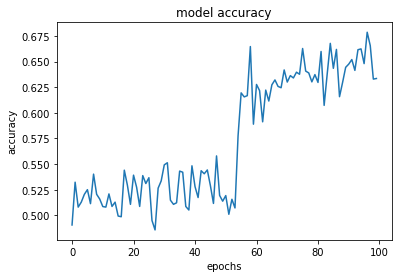

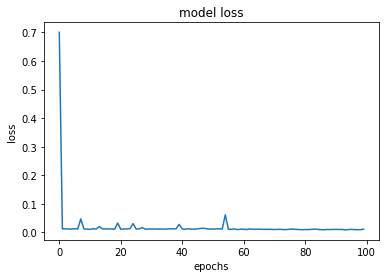

In [ ]:
# graph summary for accuracy
plt.plot(gan_model.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

# graph summary for loss
plt.plot(gan_model.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
# Validation for model
validation_input_gray_lab = rgb2lab(gray2rgb(test_input))[:, :, :, 0]
validation_input_gray_lab = validation_input_gray_lab.reshape(validation_input_gray_lab.shape + (1,))
validation_output_rgb_lab = rgb2lab(test_output)[:, :, :, 1:]
validation_output_rgb_lab = validation_output_rgb_lab / 128
print(model.evaluate(validation_input_gray_lab, validation_output_rgb_lab, batch_size=batch_size))

In [ ]:
# Load black and white images
unknown_test_sample_gray = []
for filename in os.listdir(TEST_DIR):
    gray_scale_test_image = img_to_array(load_img(TEST_DIR + filename))
    gray_scale_test_image = resize(gray_scale_test_image, (height, width), mode='constant', preserve_range=True)
    unknown_test_sample_gray.append(gray_scale_test_image)
unknown_test_sample_gray_cpy = unknown_test_sample_gray
unknown_test_sample_gray = np.array(unknown_test_sample_gray, dtype=float)
unknown_test_sample_gray = rgb2lab(1.0 / NORMALIZATION_FACTOR * unknown_test_sample_gray)[:, :, :, 0]
unknown_test_sample_gray = unknown_test_sample_gray.reshape(unknown_test_sample_gray.shape + (1,))

In [ ]:
# Test model
predictions = model.predict(unknown_test_sample_gray)
predictions = predictions * 128

# Output colorization
for prediction in range(len(predictions)):
    prediction_lab = np.zeros((256, 256, 3))
    prediction_lab[:, :, 0] = unknown_test_sample_gray[prediction][:, :, 0]
    prediction_lab[:, :, 1:] = predictions[prediction]
    prediction_rgb = lab2rgb(prediction_lab)
    color_img_plt = plt.imshow(prediction_rgb)
    plt.show()
    plt.imsave(RESULTS_DIR + "img_" + str(prediction) + ".png", prediction_rgb)


# Save Model to an external file

In [ ]:
model.save("/content/drive/MyDrive/resources_neura_colorizer/neura_colorizer_model.h5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/resources_neura_colorizer/neura_colorizer_model/assets


# Loading Pre-trained Networks

In [ ]:
own_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/resources_neura_colorizer/neura_colorizer_model.h5')
own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

# Predicting using Own Model

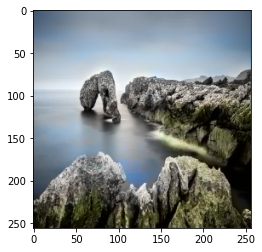

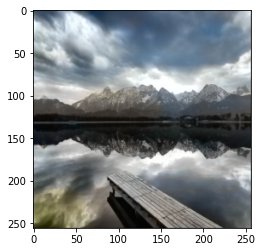

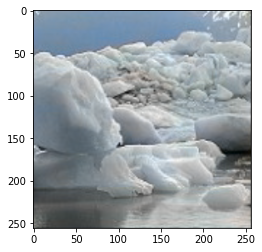

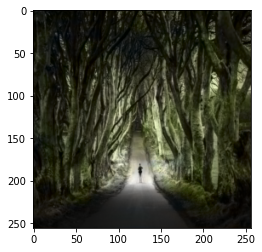

In [ ]:
# Load black and white images
unknown_test_sample_gray = []
for filename in os.listdir(TEST_DIR):
    gray_scale_test_image = img_to_array(load_img(TEST_DIR + filename))
    gray_scale_test_image = resize(gray_scale_test_image, (height, width), mode='constant', preserve_range=True)
    unknown_test_sample_gray.append(gray_scale_test_image)
unknown_test_sample_gray_cpy = unknown_test_sample_gray
unknown_test_sample_gray = np.array(unknown_test_sample_gray, dtype=float)
unknown_test_sample_gray = rgb2lab(1.0 / NORMALIZATION_FACTOR * unknown_test_sample_gray)[:, :, :, 0]
unknown_test_sample_gray = unknown_test_sample_gray.reshape(unknown_test_sample_gray.shape + (1,))

# Test model
predictions = own_model.predict(unknown_test_sample_gray)
predictions = predictions * 128

# Output colorization
for prediction in range(len(predictions)):
    prediction_lab = np.zeros((256, 256, 3))
    prediction_lab[:, :, 0] = unknown_test_sample_gray[prediction][:, :, 0]
    prediction_lab[:, :, 1:] = predictions[prediction]
    prediction_rgb = lab2rgb(prediction_lab)
    color_img_plt = plt.imshow(prediction_rgb)
    plt.show()
    plt.imsave(RESULTS_DIR + "img_" + str(prediction) + ".png", prediction_rgb)

# Prediction using Inception Resnet V2

In [ ]:
# Fused Autoencoder with Inception Resnet V2
inception_resnetv2_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/resources_neura_colorizer/inception_resnetv2_trained_model.h5')
#inception_resnetv2_model.load_weights('/content/drive/MyDrive/resources_neura_colorizer/pretrained_models/inception_resnet_v2_weights.h5')

In [ ]:
inception_resnetv2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_204 (Conv2D)            (None, 256, 256, 12  1280        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 12  0          ['conv2d_204[0][0]']             
                                8)                                                          

In [ ]:
inception_resnet = InceptionResNetV2(weights=None, include_top=True)
inception_resnet.load_weights('/content/drive/MyDrive/resources_neura_colorizer/pretrained_models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')

## Training Inception Resnet with own data

In [ ]:
def generate_inception_fused_embedding(grayscale_img):
    grayscale_img_resized = []
    for img in grayscale_img:
        img = resize(img, (299, 299, 3), mode='constant')
        grayscale_img_resized.append(img)
    grayscale_img_resized = np.array(grayscale_img_resized)
    grayscale_img_resized = preprocess_input(grayscale_img_resized)
    generated = inception_resnet.predict(grayscale_img_resized)
    return generated

In [ ]:
def image_a_b_gen_inception(batch_size):
    for batch in datagen.flow(train_output, batch_size=batch_size):
        grayscale_img = gray2rgb(rgb2gray(batch))
        generated_embed = generate_inception_fused_embedding(grayscale_img)
        lab_batch = rgb2lab(batch)
        train_input_batch = lab_batch[:, :, :, 0]
        train_input_batch = train_input_batch.reshape(train_input_batch.shape+(1,))
        train_output_batch = lab_batch[:, :, :, 1:] / 128
        yield ([train_input_batch, generated_embed], train_output_batch)

inception_resnetv2_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
inception_resnetv2 = inception_resnetv2_model.fit_generator(image_a_b_gen_inception(batch_size), steps_per_epoch=STEP_EPOCHS, epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/100
10/10 [==============================] - 26s 2s/step - loss: 0.0646 - accuracy: 0.5089
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 0.0132 - accuracy: 0.5268
Epoch 3/100
10/10 [==============================] - 20s 2s/step - loss: 0.0125 - accuracy: 0.5220
Epoch 4/100
10/10 [==============================] - 20s 2s/step - loss: 0.0115 - accuracy: 0.5404
Epoch 5/100
10/10 [==============================] - 21s 2s/step - loss: 0.0122 - accuracy: 0.5166
Epoch 6/100
10/10 [==============================] - 20s 2s/step - loss: 0.0138 - accuracy: 0.5275
Epoch 7/100
10/10 [==============================] - 20s 2s/step - loss: 0.0120 - accuracy: 0.5123
Epoch 8/100
10/10 [==============================] - 20s 2s/step - loss: 0.0117 - accuracy: 0.5417
Epoch 9/100
10/10 [==============================] - 20s 2s/step - loss: 0.0132 - accuracy: 0.5089
Epoch 10/100
10/10 [==============================] - 20s 2s/step - loss: 0.0190 - accuracy: 0.5566
Epoch 11/

In [ ]:
validation_input, unseen_input = train_test_split(test_input, test_size=0.2, random_state=25)
validation_output, unseen_output = train_test_split(test_output, test_size=0.2, random_state=25)
len(validation_input)

1140

In [ ]:
fused_embed = generate_inception_fused_embedding(unseen_input)

In [ ]:
def prediction_data(dataset):
  test_input_gray = rgb2lab(gray2rgb(dataset))[:, :, :, 0]
  test_input_gray = test_input_gray.reshape(test_input_gray.shape + (1,))
  return test_input_gray



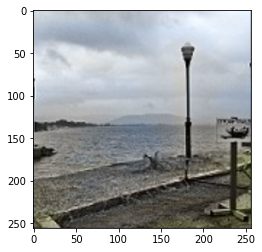

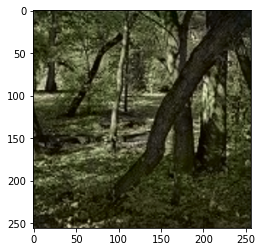

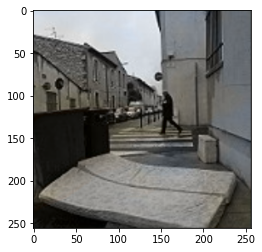

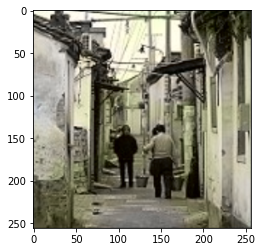

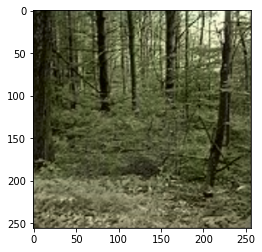

In [ ]:
# Test model
predictions_inception_resnet_v2 = inception_resnetv2_model.predict([prediction_data(unseen_input), fused_embed])
predictions_inception_resnet_v2 = predictions_inception_resnet_v2 * 128

# Output colorization
#for prediction in range(len(predictions_inception_resnet_v2)):
for prediction in range(5):

  prediction_lab = np.zeros((256, 256, 3))
  prediction_lab[:, :, 0] = prediction_data(unseen_input)[prediction][:, :, 0]
  prediction_lab[:, :, 1:] = predictions_inception_resnet_v2[prediction]
  prediction_rgb = lab2rgb(prediction_lab)
  color_img_plt = plt.imshow(prediction_rgb)
  plt.show()
  plt.imsave(RESULTS_DIR + "img_" + str(prediction) + ".png", prediction_rgb)

# Predicting on same dataset using our own Model

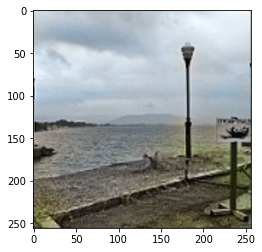

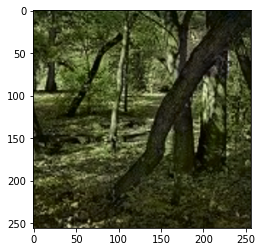

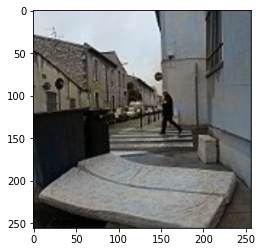

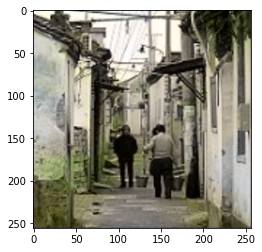

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


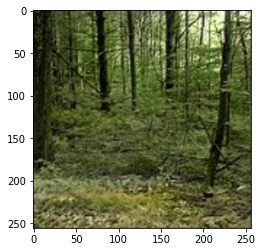

In [ ]:
# Test model
predictions = own_model.predict(prediction_data(unseen_input))
predictions = predictions * 128

# Output colorization
for prediction in range(5):
    prediction_lab = np.zeros((256, 256, 3))
    prediction_lab[:, :, 0] = prediction_data(unseen_input)[prediction][:, :, 0]
    prediction_lab[:, :, 1:] = predictions[prediction]
    prediction_rgb = lab2rgb(prediction_lab)
    color_img_plt = plt.imshow(prediction_rgb)
    plt.show()
    plt.imsave(RESULTS_DIR + "img_" + str(prediction) + ".png", prediction_rgb)

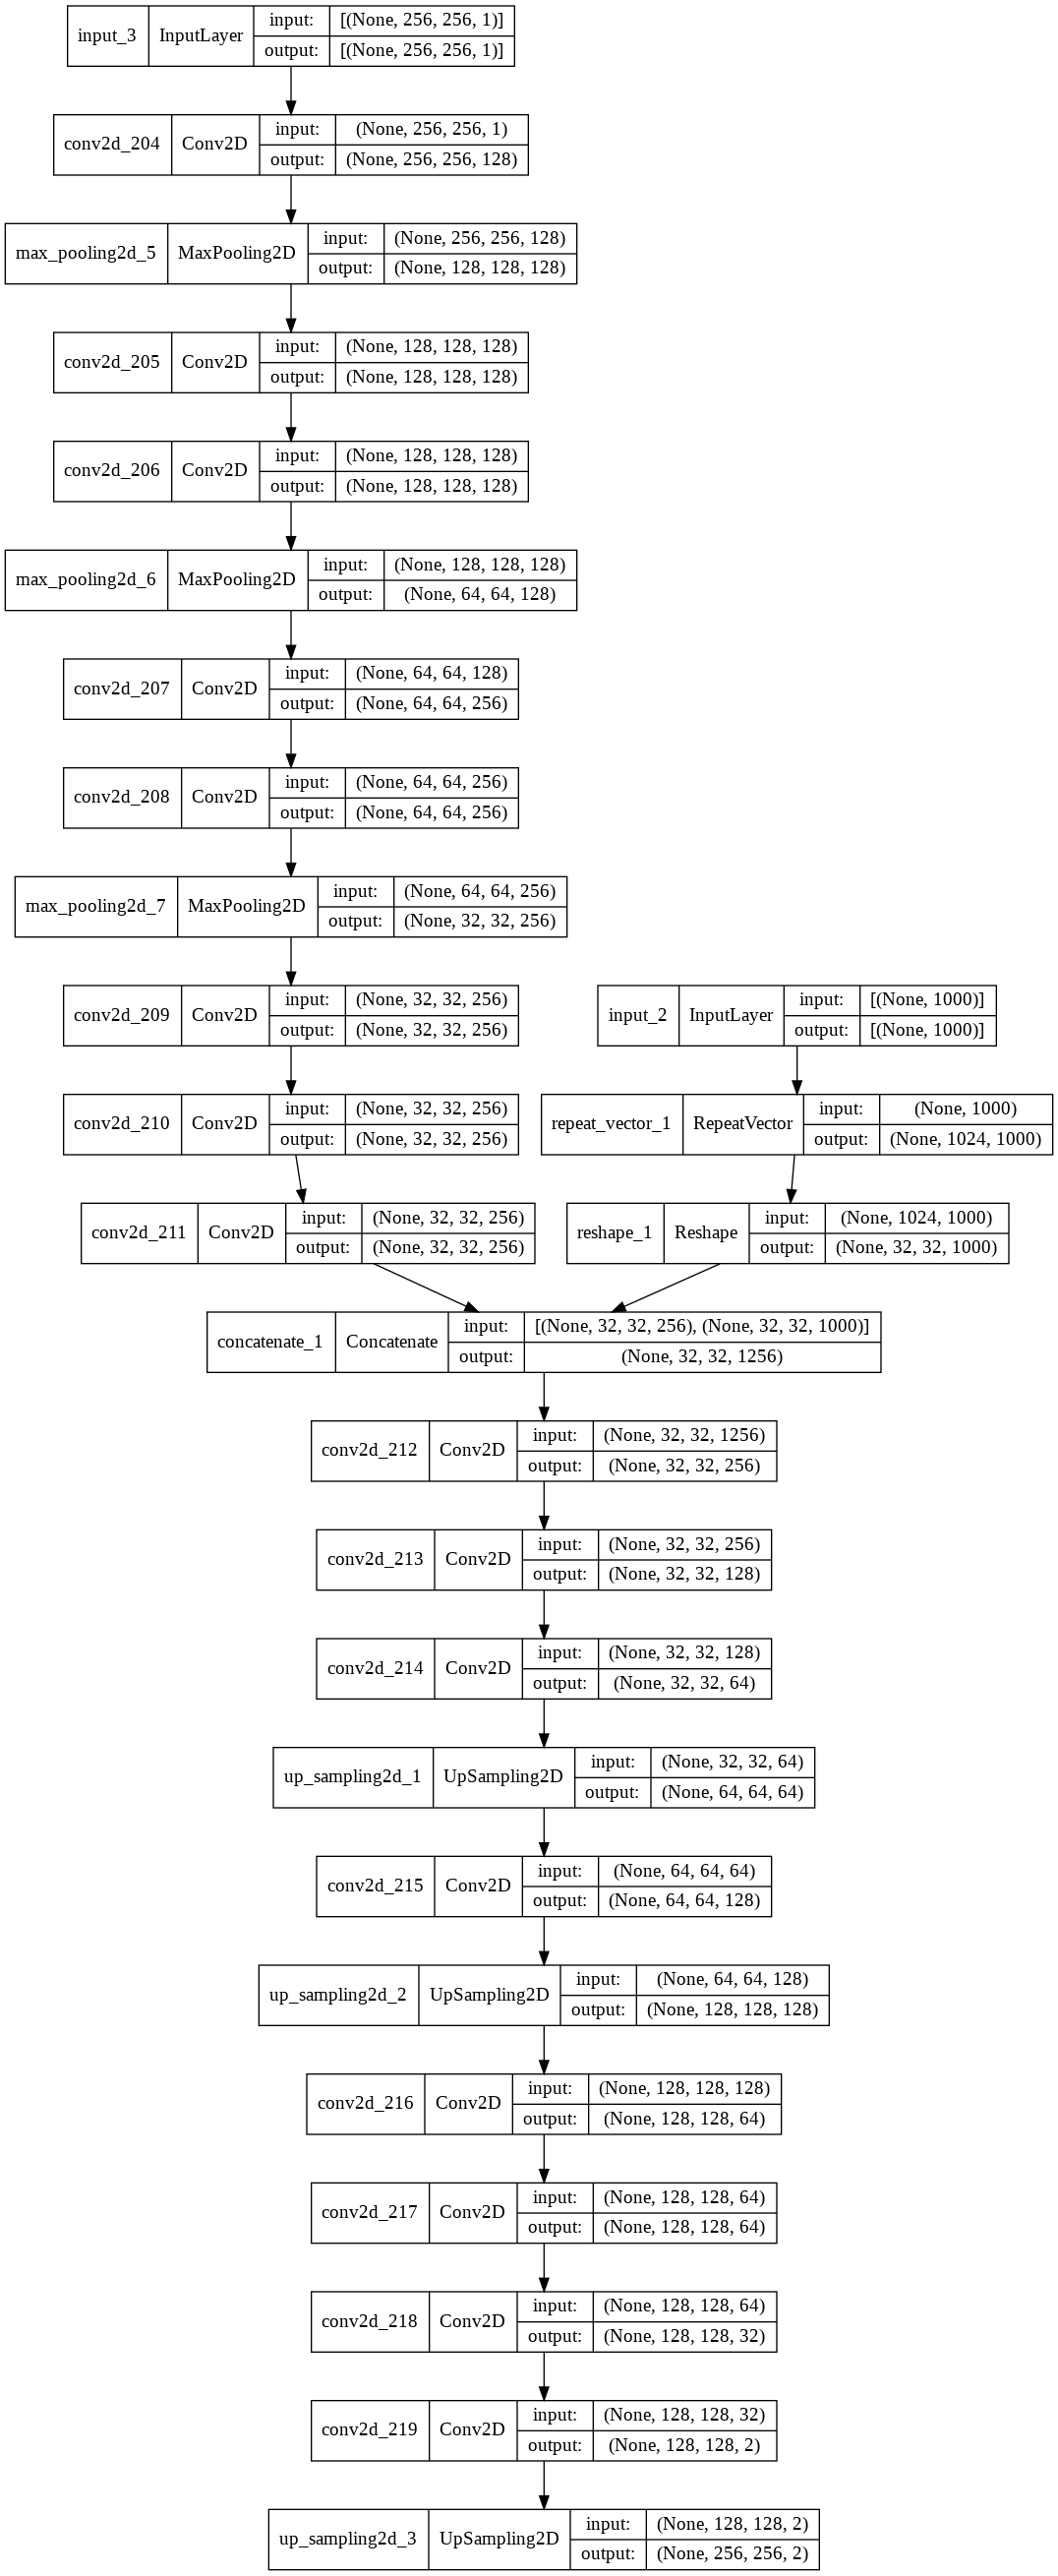

In [ ]:
tensorflow.keras.utils.plot_model(inception_resnetv2_model, show_shapes=True)

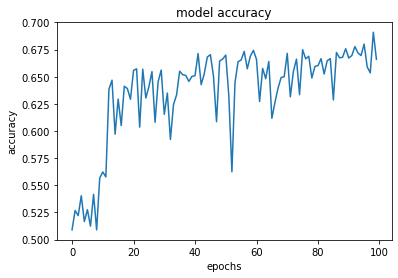

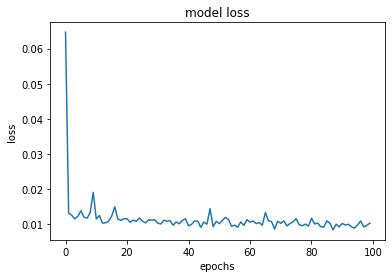

In [ ]:
# Plot History of Accuracy and Loss
# graph summary for accuracy
plt.plot(inception_resnetv2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

# graph summary for loss
plt.plot(inception_resnetv2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
inception_resnetv2_model.save("/content/drive/MyDrive/resources_neura_colorizer/inception_resnetv2_trained_model.h5")

# References

[Image Colorizer by SHUVRO MAC](https://www.kaggle.com/shuvromac/final-version-colorization)